# This notebook reproduces the complete analysis from Rocklin et al., 2017, Science

In [1]:
# Import `Python` modules
import os
import sys
import pandas
import scipy.stats
import numpy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
# Define input variables
data_dir = 'data/Rocklin_2017_Science/'
designed_sequences_file = os.path.join(data_dir, 'designed_protein_sequences.csv')
experimental_summary_file = os.path.join(data_dir, 'experimental_summary.csv')
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/archive/ingest/Q0/sd2.biofab.upload/Rocklin_ProtStab/'
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = 'results/'

Call the python script

In [3]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/Rocklin_2017_Science/designed_protein_sequences.csv --experimental_summary_file data/Rocklin_2017_Science/experimental_summary.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/archive/ingest/Q0/sd2.biofab.upload/Rocklin_ProtStab/ --pear_path /home/05402/haddox/software/pear/bin/pear --output_dir results/


## Make sure the protein counts generated by the pipeline match the original protein counts reported by the Rocklin et al. study

Read in names and sequences of all input designs

In [4]:
designed_seqs_df = pandas.read_csv(designed_sequences_file)
designed_seqs_df.set_index('name', inplace=True)

Read in counts from the above pipeline

In [5]:
proteases = ['chymotrypsin', 'trypsin']
counts_dfs = {
    'pipeline' : {},
    'original' : {}
}
counts_dir = os.path.join(output_dir, 'counts/')

for protease in proteases:
    df = pandas.read_csv(os.path.join(counts_dir, '{0}.counts'.format(protease)), sep=' ')
    df.set_index('name', inplace=True)
    print("Number of sequences for {0} with zero starting counts : {1}".format(
        protease,
        sum(df['counts0'] == 0)
    ))    
    counts_dfs['pipeline'][protease] = df

Number of sequences for chymotrypsin with zero starting counts : 0
Number of sequences for trypsin with zero starting counts : 0


Read in counts from the initial study, removing sequences with zero starting counts

In [6]:
# Read in the counts from the original study
for protease in proteases:
    if protease == 'chymotrypsin':
        df = pandas.read_csv('data/original_Rocklin_counts/rd4_chymo.counts', sep=' ')
    elif protease == 'trypsin':
        df = pandas.read_csv('data/original_Rocklin_counts/rd4_tryp.counts', sep=' ')
    else:
        raise ValueError()
    df.set_index('name', inplace=True)
    print("Number of sequences for {0} with zero starting counts : {1}".format(
        protease,
        sum(df['counts0'] == 0)
    ))
    
    counts_dfs['original'][protease] = df

Number of sequences for chymotrypsin with zero starting counts : 9
Number of sequences for trypsin with zero starting counts : 7


Count the number of sequences in each dataset

In [7]:
# Get a list of sequence names in each dataset
original_trypsin_seqs = list(counts_dfs['original']['trypsin'].index.values)
pipeline_trypsin_seqs = list(counts_dfs['pipeline']['trypsin'].index.values)
original_chymotrypsin_seqs = list(counts_dfs['original']['chymotrypsin'].index.values)
pipeline_chymotrypsin_seqs = list(counts_dfs['pipeline']['chymotrypsin'].index.values)
input_seqs = designed_seqs_df.index.values

# Check that all sequences are unique
for seqs in [
    original_trypsin_seqs, pipeline_trypsin_seqs, original_chymotrypsin_seqs,
    pipeline_chymotrypsin_seqs, input_seqs
]:
    assert(len(seqs) == len(set(seqs)))

# Print the results
print("Number of input sequences is: {0}".format(len(input_seqs)))
print("Number of sequences with counts from the original study for trypsin and chymotrypsin is: {0} and {1}".format(
    len(original_trypsin_seqs), len(original_chymotrypsin_seqs)
))
print("Number of sequences with counts from the pipeline for trypsin and chymotrypsin is: {0} and {1}".format(
    len(pipeline_trypsin_seqs), len(pipeline_chymotrypsin_seqs)
))

Number of input sequences is: 19704
Number of sequences with counts from the original study for trypsin and chymotrypsin is: 19697 and 19680
Number of sequences with counts from the pipeline for trypsin and chymotrypsin is: 19690 and 19671


Quantify the number of sequences that overlap with the input sequences

In [8]:
print("Number of overlapping sequences between the following trypsin datasets:")
print("Input sequences and the orignal counts: {0}".format(
    len(set.intersection(set(input_seqs), set(original_trypsin_seqs))))
)
print("Input sequences and the pipeline counts: {0}".format(
    len(set.intersection(set(input_seqs), set(pipeline_trypsin_seqs))))
)

print("Number of overlapping sequences between the following chymotrypsin datasets:")
print("Input sequences and the orignal counts: {0}".format(
    len(set.intersection(set(input_seqs), set(original_chymotrypsin_seqs))))
)
print("Input sequences and the pipeline counts: {0}".format(
    len(set.intersection(set(input_seqs), set(pipeline_chymotrypsin_seqs))))
)

#print(len(set.intersection(set(input_seqs), set(original_chymotrypsin_seqs))))
#print(len(set.intersection(set(input_seqs), set(pipeline_chymotrypsin_seqs))))

Number of overlapping sequences between the following trypsin datasets:
Input sequences and the orignal counts: 19683
Input sequences and the pipeline counts: 19690
Number of overlapping sequences between the following chymotrypsin datasets:
Input sequences and the orignal counts: 19666
Input sequences and the pipeline counts: 19671


In [9]:
# Report the number of input sequences and the number of sequences with counts data for
# each protease and for the original Rocklin data vs. the pipeline data

# Quantify the number of sequences that are overlapping between the two datasets
overlapping_trypsin_seqs = set.intersection(set(original_trypsin_seqs), set(pipeline_trypsin_seqs))
overlapping_chymotrypsin_seqs = set.intersection(set(original_chymotrypsin_seqs), set(pipeline_chymotrypsin_seqs))
print("Number of sequences that overlap is:")
print("{0} for trypsin".format(len(overlapping_trypsin_seqs)))
print("{0} for chymotrypsin".format(len(overlapping_chymotrypsin_seqs)))

Number of sequences that overlap is:
19676 for trypsin
19657 for chymotrypsin


In [10]:
corr_dict = {
    key : []
    for key in ['protease', 'selection_index', 'pearson_r']
}
selection_indices = [i for i in range(0,7)]
for protease in proteases:    
    for selection_index in selection_indices:

        # Define sequences that are shared between the two replicates
        seqs1 = counts_dfs['original'][protease].index.values
        seqs2 = counts_dfs['pipeline'][protease].index.values
        shared_seqs = set.intersection(set(seqs1), set(seqs2))
        
        # Add text with correlation coefficient to plots
        x = counts_dfs['original'][protease].loc[shared_seqs]['counts{0}'.format(selection_index)]
        y = counts_dfs['pipeline'][protease].loc[shared_seqs]['counts{0}'.format(selection_index)]
        (r,p) = scipy.stats.pearsonr(x, y)
        corr_dict['protease'].append(protease)
        corr_dict['selection_index'].append(selection_index)
        corr_dict['pearson_r'].append(r)

        if False:
            g = sns.jointplot(x=x, y=y)

            # Make the plot square with the same ranges, add title, and fix axis labels
            max_freq = max(x + y)
            g.set_axis_labels(xlabel='original', ylabel='pipeline')

            #plt.text(0.05, 0.75, '$R$ = {0}'.format(round(r, 2)), transform=ax.transAxes)

            plt.axis('equal')
            plt.tight_layout()
            plt.show()
            
corr_df = pandas.DataFrame.from_dict(corr_dict)
corr_df.set_index(['protease', 'selection_index'], inplace=True)
corr_df

pearson_r
protease     selection_index           
chymotrypsin 0                      1.0
             1                      1.0
             2                      1.0
             3                      1.0
             4                      1.0
             5                      1.0
             6                      1.0
trypsin      0                      1.0
             1                      1.0
             2                      1.0
             3                      1.0
             4                      1.0
             5                      1.0
             6                      1.0

## Make sure the EC50 values generated by the pipeline match the original protein counts reported by the Rocklin et al. study

Define the input files.

In [11]:
# Make a list of input files for each replicate for the trypsin selections
replicates = ['original', 'pipeline']
trypsin_files = {
    'original' : 'data/original_Rocklin_EC50_values/rd4_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput',
    'pipeline' : 'results/ec50_values/trypsin.fulloutput'
}

# Make a list of input files for each replicate for the chymotrypsin selections
chymo_files = {
    'original' : 'data/original_Rocklin_EC50_values/rd4_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput',
    'pipeline' : 'results/ec50_values/chymotrypsin.fulloutput'
}

Read in the data, filter sequences with low confidence, and report the number filters.

In [12]:
summary_dict = {
    key : []
    for key in ['protease', 'replicate', 'staring_number_of_seqs', 'number_of_seqs_after_filtering']
}

trypsin_ec50_df = pandas.DataFrame()
chymo_ec50_df = pandas.DataFrame()
for (protease, files_d) in [('trypsin', trypsin_files), ('chymotrypsin', chymo_files)]:

    for replicate in files_d:
        
        # Read in data
        infile = files_d[replicate]
        df = pandas.read_csv(infile, sep='\t')
        df.set_index('name', inplace=True)

        # Throw out sequences where the 95% CI of the EC50 is greater than 0.95 * EC50
        summary_dict['protease'].append(protease)
        summary_dict['replicate'].append(replicate)
        summary_dict['staring_number_of_seqs'].append(len(df.index.values))
        df = df[df['ec50_95ci'] < 0.95 * df['ec50']]
        summary_dict['number_of_seqs_after_filtering'].append(len(df.index.values))
        
        # Rename the `ec50` column with the name of the replicate
        df.rename(index=str, columns={'ec50' : replicate}, inplace=True)

        if protease == 'trypsin':
            trypsin_ec50_df = trypsin_ec50_df.merge(
                df[[replicate]], left_index=True, right_index=True, how='outer'
            )
        elif protease == 'chymotrypsin':
            chymo_ec50_df = chymo_ec50_df.merge(
                df[[replicate]], left_index=True, right_index=True, how='outer'
            )
            
summary_df = pandas.DataFrame.from_dict(summary_dict)
summary_df.set_index(['protease', 'replicate'], inplace=True)
summary_df[['staring_number_of_seqs', 'number_of_seqs_after_filtering']]

staring_number_of_seqs  number_of_seqs_after_filtering
protease     replicate                                                        
trypsin      original                    19697                           15803
             pipeline                    19690                           15745
chymotrypsin original                    19680                           14089
             pipeline                    19671                           14003

Plot the correlation in EC50 values among the sequences that passed the above filter.

Plotting EC50 values for trypsin


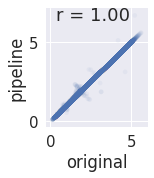

Plotting EC50 values for chymotrypsin


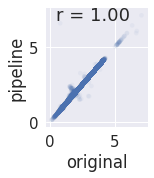

In [13]:
def corrfunc(x, y, contour, **kws):
    ncontours=10
    
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
    if contour:
        sns.kdeplot(x, y, shade=True, n_levels=ncontours)
    else:
        plt.scatter(x, y, s=22, alpha=0.05, marker='o', edgecolor='none', rasterized=True)

labels = ['original', 'pipeline']
for (protease, protease_df) in [('trypsin', trypsin_ec50_df), ('chymotrypsin', chymo_ec50_df)]:
    print("Plotting EC50 values for {0}".format(protease))
    p = sns.PairGrid(protease_df.dropna(how='any'), vars=labels)
    p.set(
        xticks=[0, 5],
        yticks=[0, 5],
    )
    
    # Hide the plots above the diagonal
    for (i, j) in zip(*numpy.triu_indices_from(p.axes, 1)):
        p.axes[i, j].set_visible(False)
    for (i, j) in zip(*numpy.diag_indices_from(p.axes)):
        p.axes[i, j].set_visible(False)
    
    # Show correlation coefficients on plots
    p.map_lower(corrfunc, contour=False)
    
    #plt.xscale('log')
    #plt.yscale('log')
    plt.show()

## Test code for computing stability scores from EC50 values

In [ ]:
stability_scores = []
for protease in proteases:

    ec50s_file = 'results/ec50_values/{0}.fulloutput'.format(protease)
    df = pandas.read_csv(ec50s_file, sep='\t')
    break
    
    # Compute the difference between the observed EC50 value and
    # the EC50 value expected for the unfolded protein
    df['ec50_rise_{0}'.format(protease)] = \
        df['{0}_calc_EC50'.format(protease)] - \
        df['{0}_unfolded_EC50'.format(protease)]

    # Compute a stability score based on the above difference
    df['stabilityscore_{0}'.format(protease)] = \
        df['ec50_rise_{0}'.format(protease)].apply(
            lambda x: np.log10(np.power(3,x))
        )
    stability_scores.append(df['stabilityscore_{0}'.format(protease)])

#df['stabilityscore'] = min(stability_scores)
df